# Automatic diagnosis of Alzheimer's disease using Deep Learning

## Introduction

Alzheimers 

"Alzheimer's disease (AD), also referred to simply as Alzheimer's, is a chronic neurodegenerative disease that usually starts slowly and gradually worsens over time. It is the cause of 60–70% of cases of dementia. The most common early symptom is difficulty in remembering recent events. As the disease advances, symptoms can include problems with language, disorientation (including easily getting lost), mood swings, loss of motivation, not managing self-care, and behavioural issues. As a person's condition declines, they often withdraw from family and society. Gradually, bodily functions are lost, ultimately leading to death. Although the speed of progression can vary, the typical life expectancy following diagnosis is three to nine years." -wikipedia.org

For this lab, we are going to use the following packages:

- nibabel
- tensorflow 2.0 or greater
- tensorboard
- nilearn
- numpy
- scikit-learn

Furthermore, for some preprocessing we use:
- Matlab 2019b

Please make sure he have installed all required packages for python and installed Matlab. We suggest that you use anaconda and create an new python environment 

## PET Scan Images: Analysing the brain

A positron emission tomography (PET) scan is an imaging test that allows your doctor to check for diseases in your body.
The scan uses a special dye containing radioactive tracers. These tracers are either swallowed, inhaled, or injected into a vein in your arm depending on what part of the body is being examined. Certain organs and tissues then absorb the tracer.
When detected by a PET scanner, the tracers help your doctor to see how well your organs and tissues are working.

Glucose is the main fuel of the brain. During PET scans, tracers are “attached” to compounds such as glucose. By detecting radioactive glucose, the PET scan is able to detect which areas of the brain are utilizing glucose at the highest rates.

PET scans are used to help diagnose and manage many central nervous system (CNS) disorders, such as Alzheimer's disease

### Visualizing the Data

Before we do any preperations on the images we are going to use for our classificaiton study, it is always a good idea to inspect the data. This way we can identfiy issues that would need to be resolved, such as normalizing, removing noisy images, segment important parts or crop/resize the image. 

Lets import some modules:

In [1]:
#Loading modules
import os 
import sys
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
import tensorflow as tf
print(tf.__version__)
from nilearn.plotting import view_img
import nibabel as nib

2024-02-18 16:03:29.314765: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-18 16:03:29.317350: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 16:03:29.346484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 16:03:29.346504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 16:03:29.347529: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

2.15.0


Our images are in 3D NIFTI format. To load this type of data, we use the python library nibabel: 

In [2]:
IMG_BASE_PATH = os.path.dirname(os.path.abspath("Lab.ipynb"))
example_brain1_path = os.path.join(IMG_BASE_PATH, 'normal_raw', 's123_S_0106-0004-02001-000081.nii')
example_brain2_path = os.path.join(IMG_BASE_PATH, 'normal_raw', 's126_S_0680-0003-00001-000047.nii')
example_brain3_path = os.path.join(IMG_BASE_PATH, 'normal_raw', 's129_S_4422-0001-00001-000001.nii')

example_brain1 = nib.load(example_brain1_path)
example_brain2 = nib.load(example_brain2_path)
example_brain3 = nib.load(example_brain3_path)


After loading three examples, we can plot them using the nilearn library. Nilearn is similar to sklearn, providing tool and algorithms for neuro-imaging tasks. We primarily use the nice plotting utilities of this library. Lets plot the three examples: 

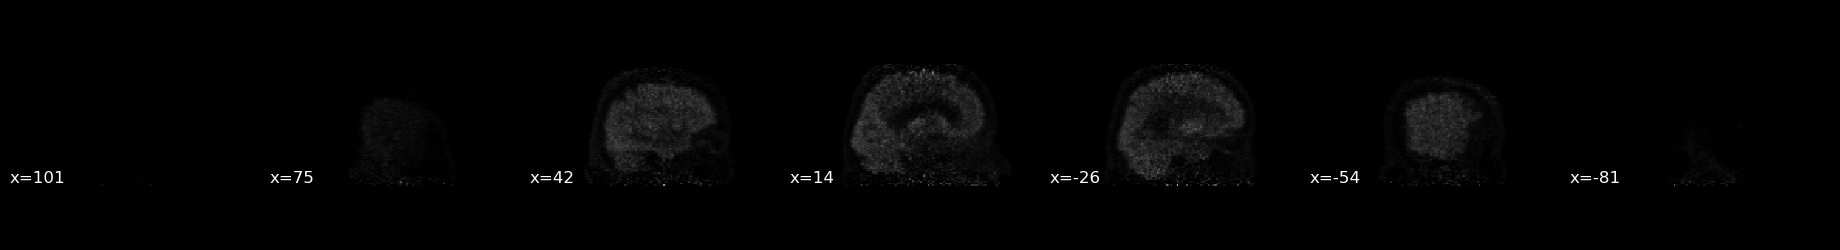

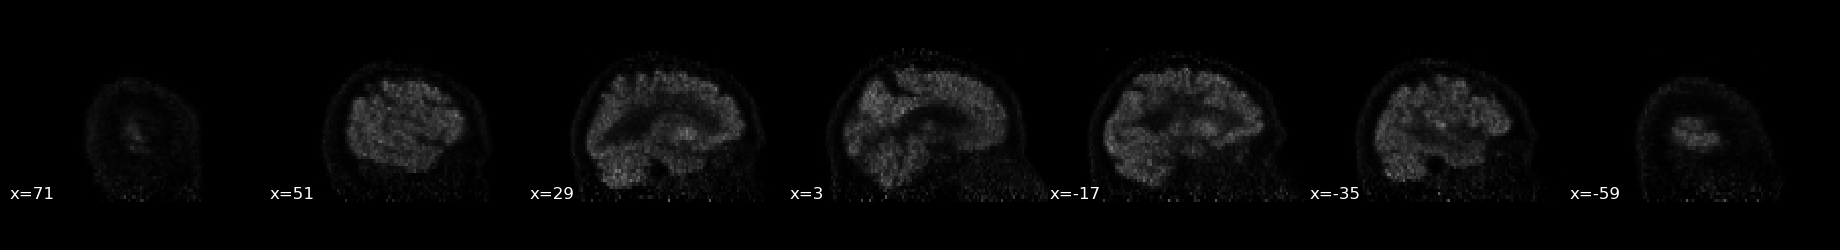

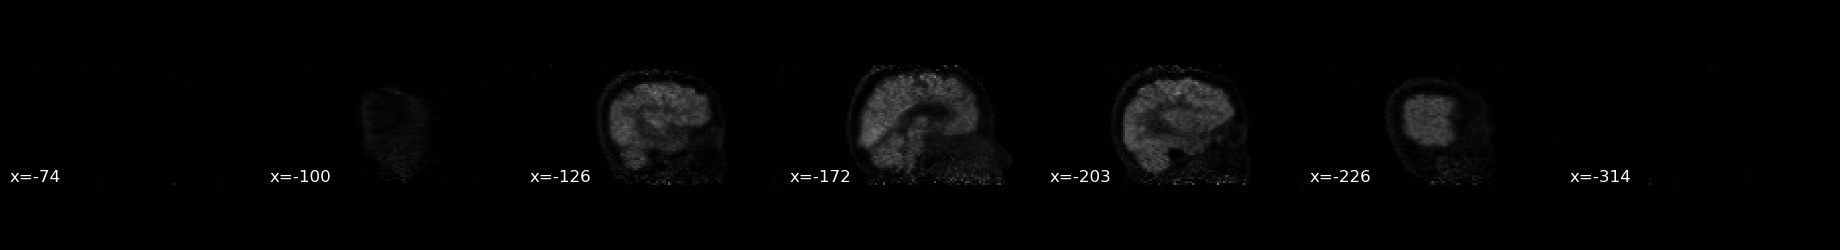

In [3]:
#import plotting functions
from nilearn.plotting import view_img, plot_anat

#display brains
plot_anat(example_brain1, draw_cross=False, display_mode ="x")
plot_anat(example_brain2, draw_cross=False, display_mode ="x")
plot_anat(example_brain3, draw_cross=False, display_mode ="x")

If you want to learn more about a particular functions and its parameters use "?" after the function name:

In [4]:
plot_anat?

Play around with the parameters to show different views of the data. For example, change the <strong>display_mode</strong> parameter to "x" to show a sagittal view of the skull. There are more brains in the example folder, display them to get a better idea what problems you may need to solve before you can construct your classifcation model.

### Problems using the raw data directly

You may have noticed that images come in differnt sizes, the brightness of the images are different. Most images contain the skull and other soft tissues aside from the brain. To get good results for our classifcation problem, we need preprocess the data. Before we do this, run the following command:

In [5]:
example_brain = nib.load(example_brain1_path)

# Display the image
view_img(example_brain)


/nfs/home/mohham19/deeplearn/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


BoundingBoxError: The field of view given by the target affine does not contain any of the data

You might get the error: "The field of view given by the target affine does not contain any of the data". This happens because the image origin is not set appropriatly and the plotting functions does not find any data in the area where the origin is set. We will elivate this problem and do other preprocessing steps in the next sections.

## Learning to classify unhealthy brains

### Preprocessing
For the normalizing steps, we will use Matlab with the Statistical Parameter Mapping (SPM) library, allowing the fast and easy visualization of nifti image files. You can do much more with this library, but we concentrate on preprocessing our raw files for classifcation.
#### Normalizing Images using Matlab and SPM

##### Installing SPM

1. Make sure that you have newest version of Matlab installed (2019b). Download SPM12 from the following link:
https://www.fil.ion.ucl.ac.uk/spm/software/download/

You are required to fill in a short form. You don't need to fill in "Additional Comments"!. 

2. After downloading the spm12.zip. We recomment you to unpack the zip file in the main folder of this lab.

3. Open Matlab and type into the command window to add SPM to the working directory:
`addpath <path to SPM folder>`

Were `<path to SPM folder>` is the path where you unpacked the zip file: For example:
`addpath C:\Lab\SPM\`

4. Type `spm` into the command window to start SPM. This may take a while.

5. You will see a small window, click on `PET & VBM`.

##### Importing dicom images

We have seen how to plot nifti files, but petscan usually come as single images of slices, so called dicom files, that need to be compiled into 3D nifti file. 

1. To do this, click on "DICOM Import" under "SPM for PET & VBM" in the menu.
2. In the Batch Editor window on the right side click on `DICOM files      <-X`. a new window will open.
3. Select the *dcm files in the dcm_files folder and click "Done"
4. In the Batch Editor window again, select the `Output directory` and select the nii_files folder in the Lab folder.
5. In the Batch Editor window, click the green triangle on the task bar to start the conversion.

##### Setting the Image origin

Now that you have converted the dicom files to nifti, we need to set the origin of the image. This is required not only for plotting the data later, but for our preprocessing algorithms to work properly.

1. In the SPM menu, click on Display
2. Select one of the nifti files in the folder nii_files

You will see a view of the image in the Graphics window. The origin of the nifti file sould be set to the "anterior commissure" of the brain.

If you are unsure how to do this, please refer to this video:
https://www.youtube.com/watch?v=AwNJAUKLhqY

Since our PET images are of low quality, try to find an approximate "middle" of the brain. This is most of the time good enough for the segmentation alogorithms.

3. Select the origin using the blue crosses in the image.
4. At the bottom, click on "Set Origin"
5. Click on "Reorient" and overwrite the original nifti-file.

You do not need to do this for all files. If you chose to do this only for one image, remember the file name!

##### Normalization

The brightness of the images need to be normalized to ensure even signal strength for all images.
To to this, we use the "Normalise (Est & Wri)" function in SPM

1. in the menu under "spatial pre-processing", click on the drop-down menu "Normalise" and select "Normalise (Est & Wri)".
2. in the new window, click on "Data     <-X"
3. Set image to align and image to write to the nifti file that we set the origin on.
4. Click the green triangle in the task bar to start normalization.

Normalization may take a while.

##### Segementation: Keeping the Brain

After normalizing the image, we segment the most important part: The brain.

1. In the menu under "spatial pre-processing", click on "Segment".
2. Under Data -> Channel -> Volumes set the nifti file that has been created after normalization the filename should start with "w"
3. Click the green triangle in the task bar to start segmentation.

##### Final image calculation

After segmentation, several files have been created that need to be combined into a single nifti file. To do this, we use the ImCalc tool in the menu.

1. Under Input Images set the nifti filename beginning with w then c1, c2, c3
2. Under Expression type i1.*((i2+i3+i4)>0.5)
3. Under Output Filename make the field empty (remove 'output')

after all is done. A new images has been created, you can new Display the image if you want to inspect the result!

### Loading the data into our python evironment

You may have noticed that preprocessing is quite laborious. We provide you with already preprocessed files in the folders "normal_final" and "ad_final".

We again, can use the nibabel library to load the data and view the preprocessed images:

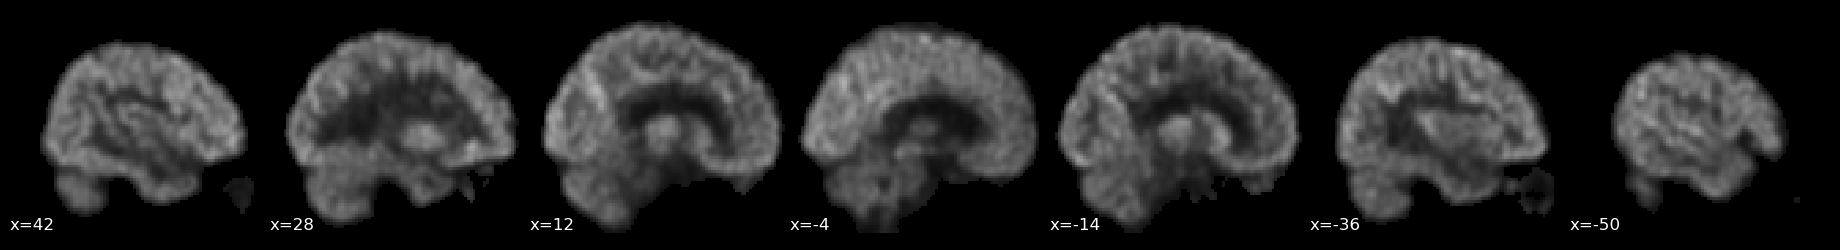

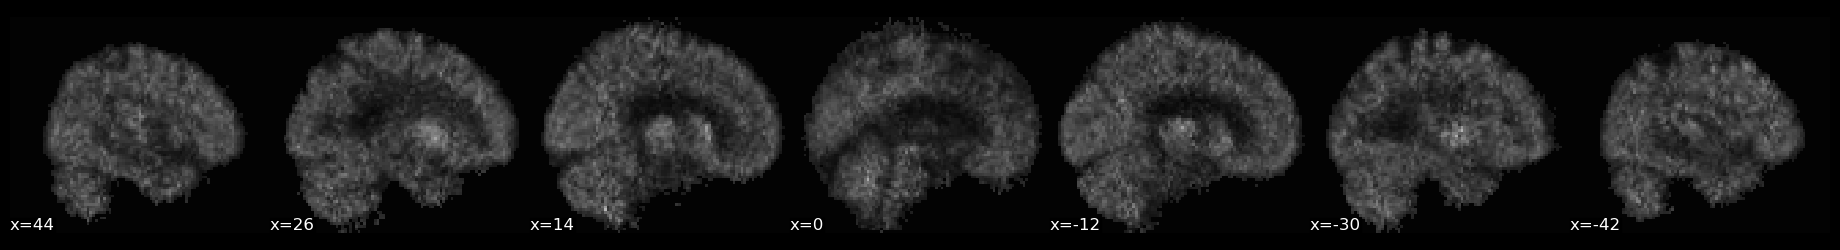

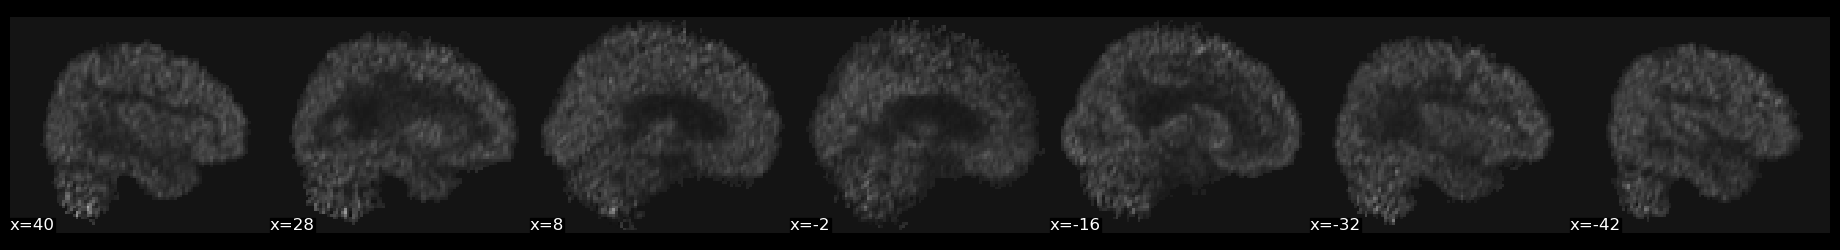

In [6]:
IMG_BASE_PATH = os.path.dirname(os.path.abspath("Lab.ipynb"))
example_brain1_path = os.path.join(IMG_BASE_PATH, 'normal_final', 'iws002_S_0413-303700-00001-000001.nii')
example_brain2_path = os.path.join(IMG_BASE_PATH, 'normal_final', 'iws003_S_0907-0006-02001-000109.nii')
example_brain3_path = os.path.join(IMG_BASE_PATH, 'normal_final', 'iws007_S_1206-0401-00047-000047.nii')

example_brain1_norm = nib.load(example_brain1_path)
example_brain2_norm = nib.load(example_brain2_path)
example_brain3_norm = nib.load(example_brain3_path)


plot_anat(example_brain1_norm, draw_cross=False, display_mode ="x")
plot_anat(example_brain2_norm, draw_cross=False, display_mode ="x")
plot_anat(example_brain3_norm, draw_cross=False, display_mode ="x")

As you can see, the skull has been removed from the images and the images are of the same size.
Since all preprocessed images have valid origins, we can use the view_img function to display an interactive plot similar to what you have seen in SPM.

/nfs/home/mohham19/deeplearn/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



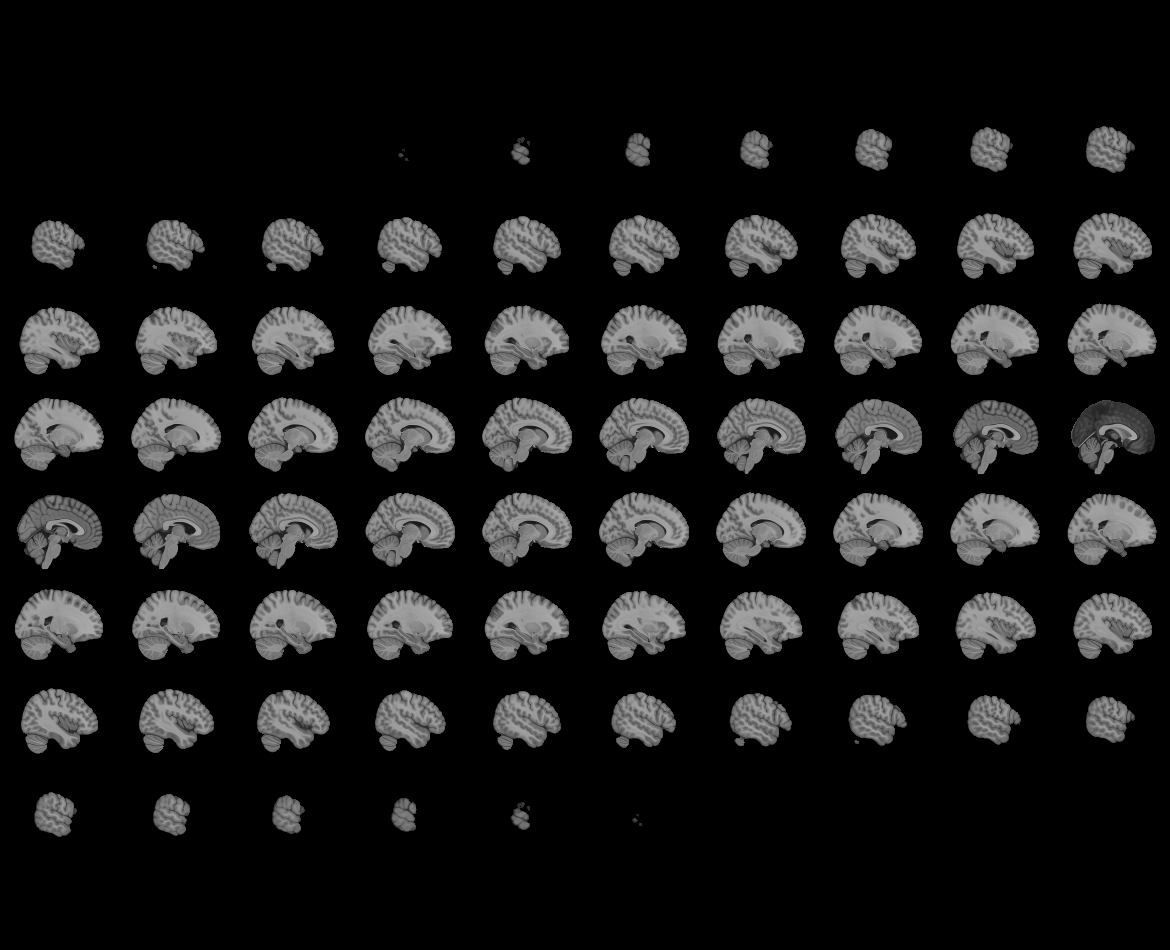
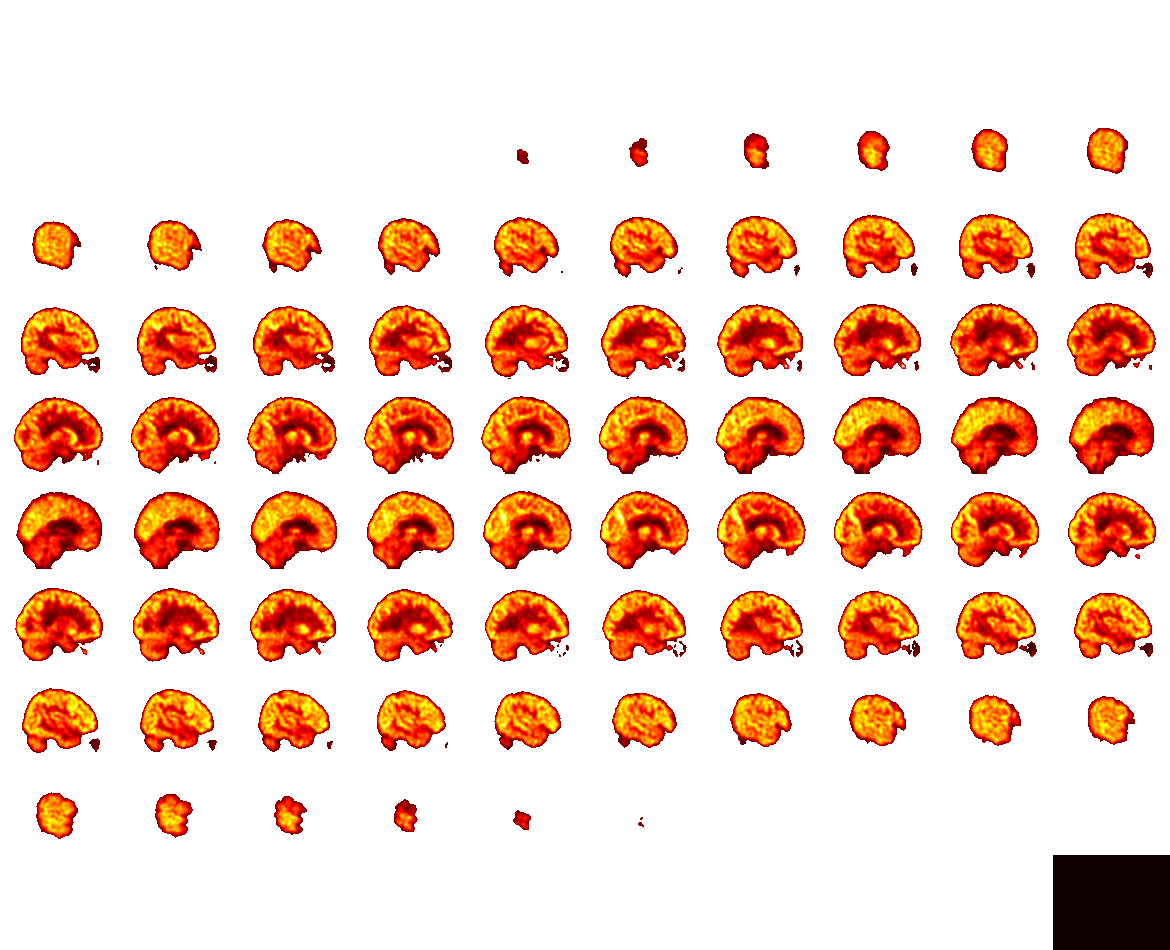

In [7]:
view_img(example_brain1_norm)

Since our model expects data input in the form of numpy arrays, we load the data and save it into variables for easy access. First we define the loading function:

In [8]:
#Loading function
def load_all_nii_data(path,filenames):
    data=[]
    temp=[]
    for i in range(0,len(filenames)):
        temp=nib.load(path+filenames[i])
        temp=temp.get_fdata()
        if i == 0:
            data=np.expand_dims(temp,0)
        else:
            data=np.append(data,np.expand_dims(temp,0),0)
    print('Data shape '+str(data.shape))
    return data,filenames

In [9]:
IMG_BASE_PATH = os.path.dirname(os.path.abspath("Lab.ipynb"))
adni_files_normal = os.listdir(f"{IMG_BASE_PATH}/normal_final/")
adni_files_ill = os.listdir(f"{IMG_BASE_PATH}/ad_final/")
adni_data_normal, normal_names = load_all_nii_data(f"{IMG_BASE_PATH}/normal_final/", adni_files_normal)
adni_data_ill, ill_names = load_all_nii_data(f"{IMG_BASE_PATH}/ad_final/", adni_files_ill)

# Concatenate into a single array
all_data = np.concatenate((adni_data_normal, adni_data_ill))

Data shape (159, 79, 95, 79)
Data shape (195, 79, 95, 79)


### Preparing the data for learning
Now that we have loaded our data, we need to prepare it for classification

#### Normalzing brightness
As you may have notices, The preprocessed images vary in brightness. To fix this, we min-max normalize our images. First lets define a function that does this for <strong>each</strong> image. 

In [10]:
def min_max_norm(x):
    # Find maximum and minimum values in the image
    max_val = x.max()
    min_val = x.min()
    
    # Perform min-max normalization
    y = (x - min_val) / (max_val - min_val) if max_val - min_val > 0 else x
    return y

And normalize the data:

In [11]:
for i in range(all_data.shape[0]):
    all_data[i, :, :, :] = min_max_norm(all_data[i, :, :, :])

#### Creating our label for learning
For our classification task, we need to tell our model what brain in our image are healthy and which are not. Lets crease our labels:

In [12]:
#placeholder array
labels= np.zeros(all_data.shape[0])

# The number of healthy (normal) brain images
num_healthy_brains = adni_data_normal.shape[0]

# Set labels to 1 for sick brains
labels[num_healthy_brains:] = 1

### Building Classification Model using Keras

Now that we have our data prepared and ready for learning, we need to define our model. We exploit the power of deep-learning models, specifically Convolutional Neural Networks, to learn to tell healthy and sick brains appart.

#### Functional API

You might be familiar with the `Sequental` model using Keras. In this Lab, we use the more powerful functional API of Keras, that allows us to design more complex model architectures. For a brief introduction, please refer to https://keras.io/getting-started/functional-api-guide/

Lets import some libraries that we need:

In [13]:
import tensorflow as tf
from pathlib import Path
import math
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras.layers import Add, Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score

In essence, the functional api allows you arbitrariy connection between layers instead of assuming a pure sequential connection between layers. It also allows you to add inputs on other layers than the input layer, providing more flexability in architecture design.

You may, for example add a skip connection between the first dense and third dense layer, "skipping" the second dense layer:

In [14]:
#input layer 100 features
input_ = Input(shape=(100,), name="input")
dense1_ = Dense(50, name="dense1")(input_)
dense2_ = Dense(50, name="dense2")(dense1_)
dense3_ = Dense(50, name="dense3")(dense2_)
dense4_ = Add(name="add")([dense1_,dense3_])
output_ = Dense(1,activation="sigmoid",name="output")(dense4_)

#create model using Model class
model = Model(inputs=input_, outputs=output_)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 100)]                0         []                            
                                                                                                  
 dense1 (Dense)              (None, 50)                   5050      ['input[0][0]']               
                                                                                                  
 dense2 (Dense)              (None, 50)                   2550      ['dense1[0][0]']              
                                                                                                  
 dense3 (Dense)              (None, 50)                   2550      ['dense2[0][0]']              
                                                                                              

2024-02-18 16:04:53.766514: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Such skip connections are heavily employed in state of the art deep neural networks for image classificaton, such as ResNet or DenseNet. For a good summary of the idea of skip connections, please see: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec.

Now it is your turn, construct a simple sequential model using the functional API. Follow the architecture instructions below. If no parameter value is given, use the standard parameters.

The model is constructed of two convolutional blocks with integrated max pooling and batch normalization:

# Name each layer (name=) for easy debugging if something goes wrong!

- INPUT
- CNN (filters = 4, kernelsize 3, strides 2, activation relu, data format channel_first)
- MAXPOOLING
- BATCHNORMALIZATION
- DROPOUT (0.3)

######

- CNN (filters = 4, kernelsize 3, strides 2, activation relu, data format channel_first)
- MAXPOOLING
- BATCHNORMALIZATION
- DROPOUT (0.3)

######

- FLATTEN

- DENSE (32)

- DENSE (16)

- OUTPUT (1)



In [15]:
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

input_shape = (79, 95, 79, 1)  
input_ = Input(shape=input_shape, name="input")

cnn1_ = Conv3D(filters=4, kernel_size=3, strides=2, activation='relu', name="cnn1")(input_)
maxpool1_ = MaxPooling3D(pool_size=(2, 2, 2), name="maxpool1")(cnn1_)
bnorm1_ = BatchNormalization(name="bnorm1")(maxpool1_)
drop1_ = Dropout(0.3, name="drop1")(bnorm1_)

cnn2_ = Conv3D(filters=4, kernel_size=3, strides=2, activation='relu', name="cnn2")(drop1_)
maxpool2_ = MaxPooling3D(pool_size=(2, 2, 2), name="maxpool2")(cnn2_)
bnorm2_ = BatchNormalization(name="bnorm2")(maxpool2_)
drop2_ = Dropout(0.3, name="drop2")(bnorm2_)

flatten_ = Flatten(name="flatten")(drop2_)
dense1_ = Dense(32, activation='relu', name="dense1")(flatten_)
dense2_ = Dense(16, activation='relu', name="dense2")(dense1_)
output_ = Dense(1, activation='sigmoid', name="output")(dense2_)

model = Model(inputs=input_, outputs=output_)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 79, 95, 79, 1)]   0         
                                                                 
 cnn1 (Conv3D)               (None, 39, 47, 39, 4)     112       
                                                                 
 maxpool1 (MaxPooling3D)     (None, 19, 23, 19, 4)     0         
                                                                 
 bnorm1 (BatchNormalization  (None, 19, 23, 19, 4)     16        
 )                                                               
                                                                 
 drop1 (Dropout)             (None, 19, 23, 19, 4)     0         
                                                                 
 cnn2 (Conv3D)               (None, 9, 11, 9, 4)       436       
                                                           

### Model Training using Tensorboard and function callbacks

#### Tensorboard
Tensorboard allows us to monitor our training progress in an easy way. First, we need to specify a folder were tensorboard saves our training progress:

In [16]:
from datetime import datetime
logdir = os.path.dirname(os.path.abspath("Lab.ipynb"))+"\\logs\\scalars\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Lets start tensorboard using the anaconda prompt:
1. Start the anaconda prompt, which is similar to the command prompt in windows
2. Activate your python environment
3. Type `tensorboard --logdir <logdir> --host localhost --port 8088` into the prompt. Replace `<logdir>` with the logs folder. 

For example type:
`tensorboard --logdir "C:\\Labs\\logs\\scalars\\" --host localhost --port 8088`
4. Open `http://localhost:8088` in your browser

##### Compiling the model and training
Lets compile our model. We define the optimizer, loss function, evaluation metric and callbacks:

In [18]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer='adam',  
              loss='binary_crossentropy',  
              metrics=[tf.keras.metrics.AUC(name="auc", dtype="float32")])  


initial_weights = model.get_weights()

In [19]:
def shuffle_weights(model, weights=None):
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    model.set_weights(weights)

Epoch 1/50
15/15 - 2s - loss: 0.7268 - auc: 0.5320 - val_loss: 0.6873 - val_auc: 0.5942 - 2s/epoch - 150ms/step
Epoch 2/50
15/15 - 1s - loss: 0.7074 - auc: 0.5745 - val_loss: 0.6872 - val_auc: 0.5625 - 509ms/epoch - 34ms/step
Epoch 3/50
15/15 - 0s - loss: 0.6877 - auc: 0.5876 - val_loss: 0.6880 - val_auc: 0.5617 - 459ms/epoch - 31ms/step
Epoch 4/50
15/15 - 1s - loss: 0.6669 - auc: 0.6167 - val_loss: 0.6873 - val_auc: 0.5505 - 505ms/epoch - 34ms/step
Epoch 5/50
15/15 - 0s - loss: 0.6441 - auc: 0.6593 - val_loss: 0.6861 - val_auc: 0.5248 - 471ms/epoch - 31ms/step
Epoch 6/50
15/15 - 0s - loss: 0.6426 - auc: 0.6780 - val_loss: 0.6838 - val_auc: 0.5753 - 486ms/epoch - 32ms/step
Epoch 7/50
15/15 - 0s - loss: 0.6538 - auc: 0.6714 - val_loss: 0.6817 - val_auc: 0.6919 - 498ms/epoch - 33ms/step
Epoch 8/50
15/15 - 0s - loss: 0.6410 - auc: 0.6619 - val_loss: 0.6832 - val_auc: 0.7212 - 469ms/epoch - 31ms/step
Epoch 9/50
15/15 - 0s - loss: 0.6136 - auc: 0.7178 - val_loss: 0.6743 - val_auc: 0.7648 - 

Epoch 22/50
15/15 - 1s - loss: 0.6078 - auc: 0.7276 - val_loss: 0.7710 - val_auc: 0.4896 - 511ms/epoch - 34ms/step
Epoch 23/50
15/15 - 0s - loss: 0.6114 - auc: 0.7305 - val_loss: 0.6856 - val_auc: 0.6486 - 492ms/epoch - 33ms/step
Epoch 24/50
15/15 - 0s - loss: 0.5888 - auc: 0.7659 - val_loss: 0.6666 - val_auc: 0.6246 - 494ms/epoch - 33ms/step
Epoch 25/50
15/15 - 0s - loss: 0.5693 - auc: 0.7724 - val_loss: 0.7214 - val_auc: 0.4900 - 471ms/epoch - 31ms/step
Epoch 26/50
15/15 - 1s - loss: 0.5577 - auc: 0.7931 - val_loss: 0.6463 - val_auc: 0.6891 - 500ms/epoch - 33ms/step
Epoch 27/50
15/15 - 0s - loss: 0.5185 - auc: 0.8263 - val_loss: 0.6290 - val_auc: 0.7568 - 489ms/epoch - 33ms/step
Epoch 28/50
15/15 - 0s - loss: 0.5104 - auc: 0.8316 - val_loss: 0.6460 - val_auc: 0.6879 - 493ms/epoch - 33ms/step
Epoch 29/50
15/15 - 0s - loss: 0.5198 - auc: 0.8146 - val_loss: 0.6245 - val_auc: 0.6899 - 487ms/epoch - 32ms/step
Epoch 30/50
15/15 - 1s - loss: 0.4915 - auc: 0.8408 - val_loss: 0.6045 - val_auc

Epoch 43/50
15/15 - 1s - loss: 0.4282 - auc: 0.8841 - val_loss: 0.4847 - val_auc: 0.8526 - 509ms/epoch - 34ms/step
Epoch 44/50
15/15 - 0s - loss: 0.4403 - auc: 0.8739 - val_loss: 0.5173 - val_auc: 0.8706 - 500ms/epoch - 33ms/step
Epoch 45/50
15/15 - 0s - loss: 0.4255 - auc: 0.8821 - val_loss: 0.4362 - val_auc: 0.9123 - 487ms/epoch - 32ms/step
Epoch 46/50
15/15 - 0s - loss: 0.3738 - auc: 0.9172 - val_loss: 0.4925 - val_auc: 0.8590 - 488ms/epoch - 33ms/step
Epoch 47/50
15/15 - 0s - loss: 0.4292 - auc: 0.8855 - val_loss: 0.4308 - val_auc: 0.8938 - 475ms/epoch - 32ms/step
Epoch 48/50
15/15 - 1s - loss: 0.3898 - auc: 0.8997 - val_loss: 0.5172 - val_auc: 0.8197 - 503ms/epoch - 34ms/step
Epoch 49/50
15/15 - 0s - loss: 0.3753 - auc: 0.9100 - val_loss: 0.4942 - val_auc: 0.8417 - 478ms/epoch - 32ms/step
Epoch 50/50
15/15 - 0s - loss: 0.3475 - auc: 0.9245 - val_loss: 0.7288 - val_auc: 0.7588 - 462ms/epoch - 31ms/step
3/3 [==============================] - 0s 9ms/step - loss: 0.7288 - auc: 0.7588


15/15 - 0s - loss: 0.5862 - auc: 0.7605 - val_loss: 0.6961 - val_auc: 0.5318 - 488ms/epoch - 33ms/step
Epoch 14/50
15/15 - 0s - loss: 0.5982 - auc: 0.7519 - val_loss: 0.7091 - val_auc: 0.5393 - 482ms/epoch - 32ms/step
Epoch 15/50
15/15 - 0s - loss: 0.5139 - auc: 0.8391 - val_loss: 0.6986 - val_auc: 0.5496 - 483ms/epoch - 32ms/step
Epoch 16/50
15/15 - 0s - loss: 0.5567 - auc: 0.7878 - val_loss: 0.6914 - val_auc: 0.5724 - 479ms/epoch - 32ms/step
Epoch 17/50
15/15 - 0s - loss: 0.5201 - auc: 0.8236 - val_loss: 0.6895 - val_auc: 0.6104 - 499ms/epoch - 33ms/step
Epoch 18/50
15/15 - 0s - loss: 0.5342 - auc: 0.8132 - val_loss: 0.7016 - val_auc: 0.6175 - 490ms/epoch - 33ms/step
Epoch 19/50
15/15 - 1s - loss: 0.5278 - auc: 0.8091 - val_loss: 0.6795 - val_auc: 0.7060 - 532ms/epoch - 35ms/step
Epoch 20/50
15/15 - 1s - loss: 0.5439 - auc: 0.7978 - val_loss: 0.6876 - val_auc: 0.7167 - 501ms/epoch - 33ms/step
Epoch 21/50
15/15 - 0s - loss: 0.5208 - auc: 0.8150 - val_loss: 0.6568 - val_auc: 0.7378 - 4

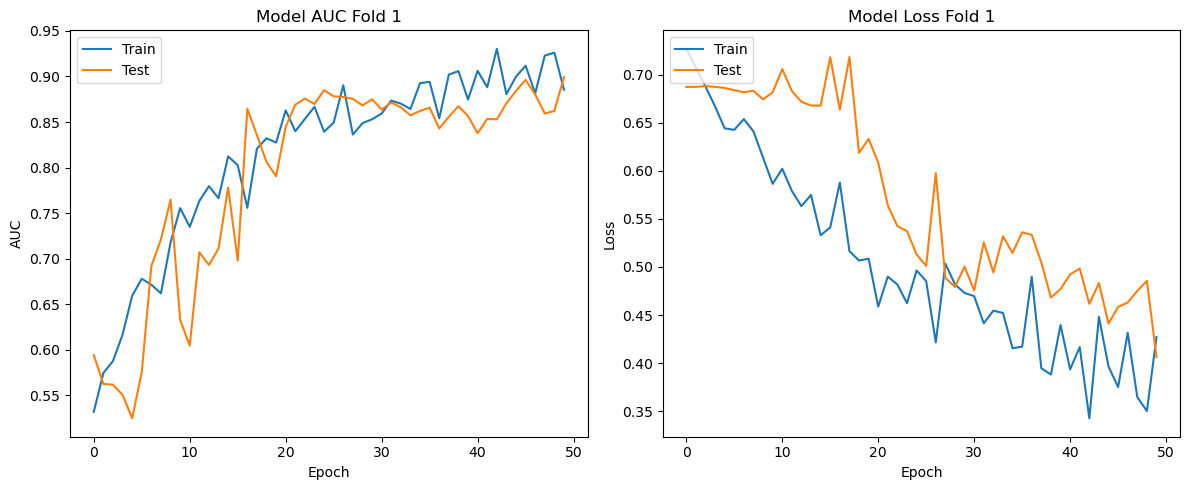

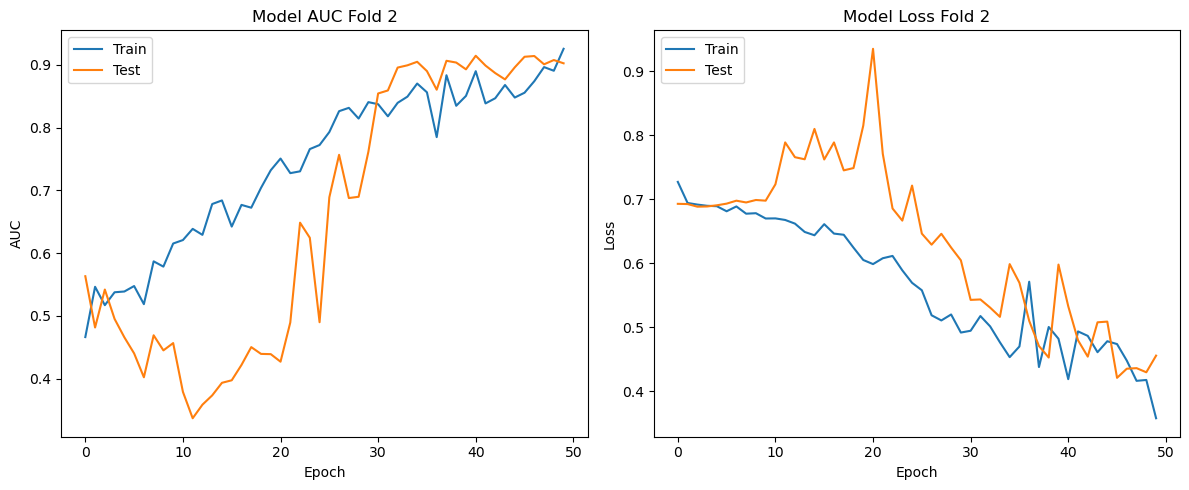

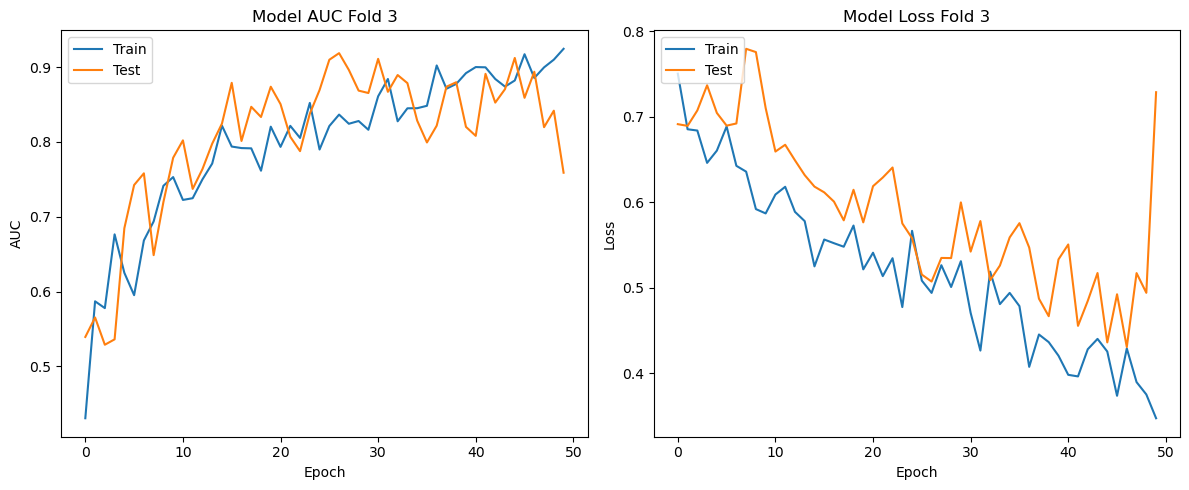

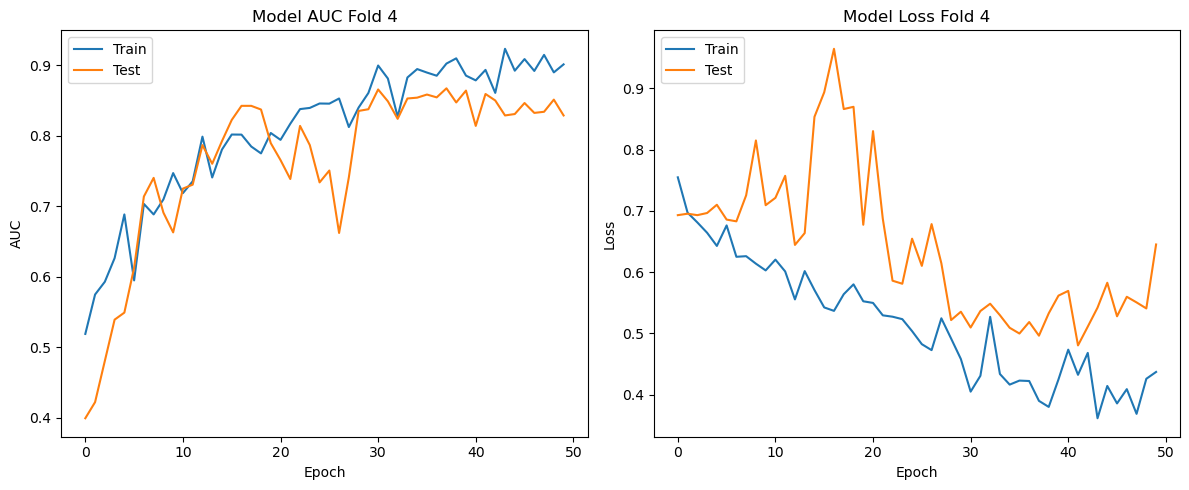

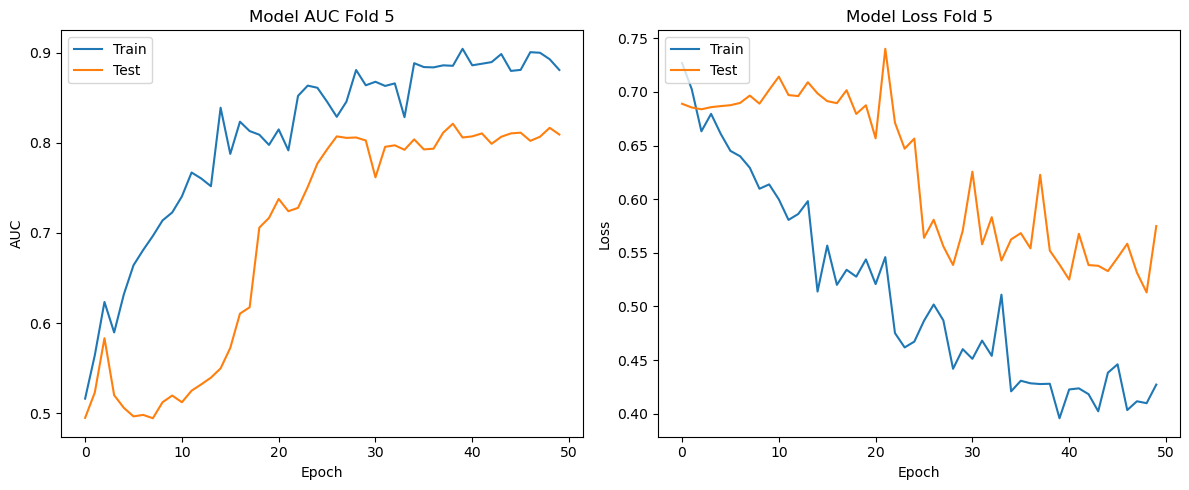

In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
BATCH_SIZE = 20
EPOCHS = 50
results = []
histories = []

for train_idx, test_idx in skf.split(all_data, labels):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name="auc")])
    
    shuffle_weights(model, initial_weights)
    
    x_train, y_train = all_data[train_idx], labels[train_idx]
    x_val, y_val = all_data[test_idx], labels[test_idx]
    
    tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

    history = model.fit(x=x_train, y=y_train, 
                        validation_data=(x_val, y_val),
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[tensorboard_callback],
                        verbose=2)
    
    histories.append(history)
    
    results.append(model.evaluate(x=x_val, y=y_val)[1])

for i, history in enumerate(histories):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title(f'Model AUC Fold {i+1}')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model Loss Fold {i+1}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [21]:
print(f"mean: {np.array(results).mean()}, std: {np.array(results).std()}")

mean: 0.8397539258003235, std: 0.05498990142925848


An AUC of about 0.75 on average! Not particuarly great!

Now it is your turn, there is room for improvement: 
    - Change the number of epochs and batch size!
    - Tweek the number of filters, add regularazation to layers or change the level of dropout!
    - You may also want to change the model architecture and add skip-connections!

After tweeking the parameters, lets train the model fully using all the data, stop training if you dont see an improvement in validation error:

Epoch 1/100
9/9 - 2s - loss: 0.3653 - auc: 0.9147 - val_loss: 0.6501 - val_auc: 0.0000e+00 - 2s/epoch - 218ms/step
Epoch 2/100
9/9 - 0s - loss: 0.3825 - auc: 0.9086 - val_loss: 0.6803 - val_auc: 0.0000e+00 - 495ms/epoch - 55ms/step
Epoch 3/100
9/9 - 0s - loss: 0.3858 - auc: 0.9043 - val_loss: 0.7117 - val_auc: 0.0000e+00 - 491ms/epoch - 55ms/step
Epoch 4/100
9/9 - 0s - loss: 0.3848 - auc: 0.9091 - val_loss: 0.7164 - val_auc: 0.0000e+00 - 490ms/epoch - 54ms/step
Epoch 5/100
9/9 - 0s - loss: 0.4092 - auc: 0.8925 - val_loss: 0.7366 - val_auc: 0.0000e+00 - 472ms/epoch - 52ms/step
Epoch 6/100
9/9 - 0s - loss: 0.3442 - auc: 0.9287 - val_loss: 0.7209 - val_auc: 0.0000e+00 - 459ms/epoch - 51ms/step
Epoch 7/100
9/9 - 0s - loss: 0.3835 - auc: 0.9093 - val_loss: 0.6934 - val_auc: 0.0000e+00 - 464ms/epoch - 52ms/step
Epoch 8/100
9/9 - 0s - loss: 0.3983 - auc: 0.8983 - val_loss: 0.6656 - val_auc: 0.0000e+00 - 457ms/epoch - 51ms/step
Epoch 9/100
9/9 - 0s - loss: 0.4183 - auc: 0.8858 - val_loss: 0.63

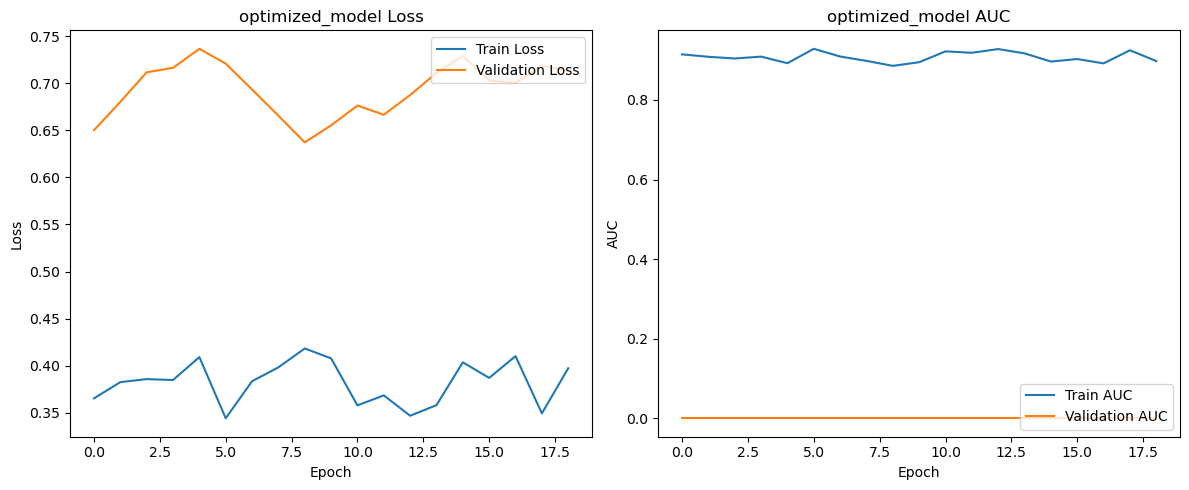

In [30]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime

BATCHSIZE = 32 
EPOCHS = 100 

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=1e-4),  
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name="auc", dtype="float32")])

history = model.fit(x=all_data,
                    y=labels, 
                    validation_split=0.2,
                    epochs=EPOCHS,
                    batch_size=BATCHSIZE,
                    callbacks=[tensorboard_callback, early_stopping_callback],
                    verbose=2)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('optimized_model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('optimized_model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### What does the model learn? Visualizing Layer activations and weights
Before we start declaring victory. It is important to inspect what the model has learned.
One way of visualizing what the model has learned is to plot the activations of the convolutional layers for a particular input. To do this, we first define some functions: 

In [23]:
def plotNNFilter(units, channel=0):
    print(units.shape)
    depth = units.shape[1]
    plt.figure(1, figsize=(20, 15))
    n_columns = 6
    n_rows = math.ceil(depth / n_columns) + 1
    for i in range(depth):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Slice ' + str(i))
        plt.imshow(units[0, i, :, :, channel].T, origin='lower', interpolation="nearest", cmap="gray")
    plt.show()


def getActivations(layer, stimuli):
    layer_name = layer
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    units = intermediate_layer_model.predict(stimuli).astype("float32")
    plotNNFilter(units)
    

def plot_filter_weights_3d(model, layer_name, max_filters=10):
    filters, biases = model.get_layer(layer_name).get_weights()
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    n_filters = filters.shape[-1]
    
    n_filters = min(n_filters, max_filters)

    fig, axes = plt.subplots(nrows=n_filters, ncols=1, figsize=(5, n_filters*3))
    if n_filters == 1:
        axes = [axes]
    
    for i in range(n_filters):
        f = filters[:, :, :, 0, i]  
        
        for j in range(f.shape[-1]):
            ax = axes[i]
            ax.imshow(f[:, :, j], cmap='gray', interpolation='none')
            ax.axis('off')
        
    plt.show()

Now we take a random image and visualize what the network extracts on the first layer:

1/1 [==============================] - 0s 47ms/step
(1, 39, 47, 39, 4)


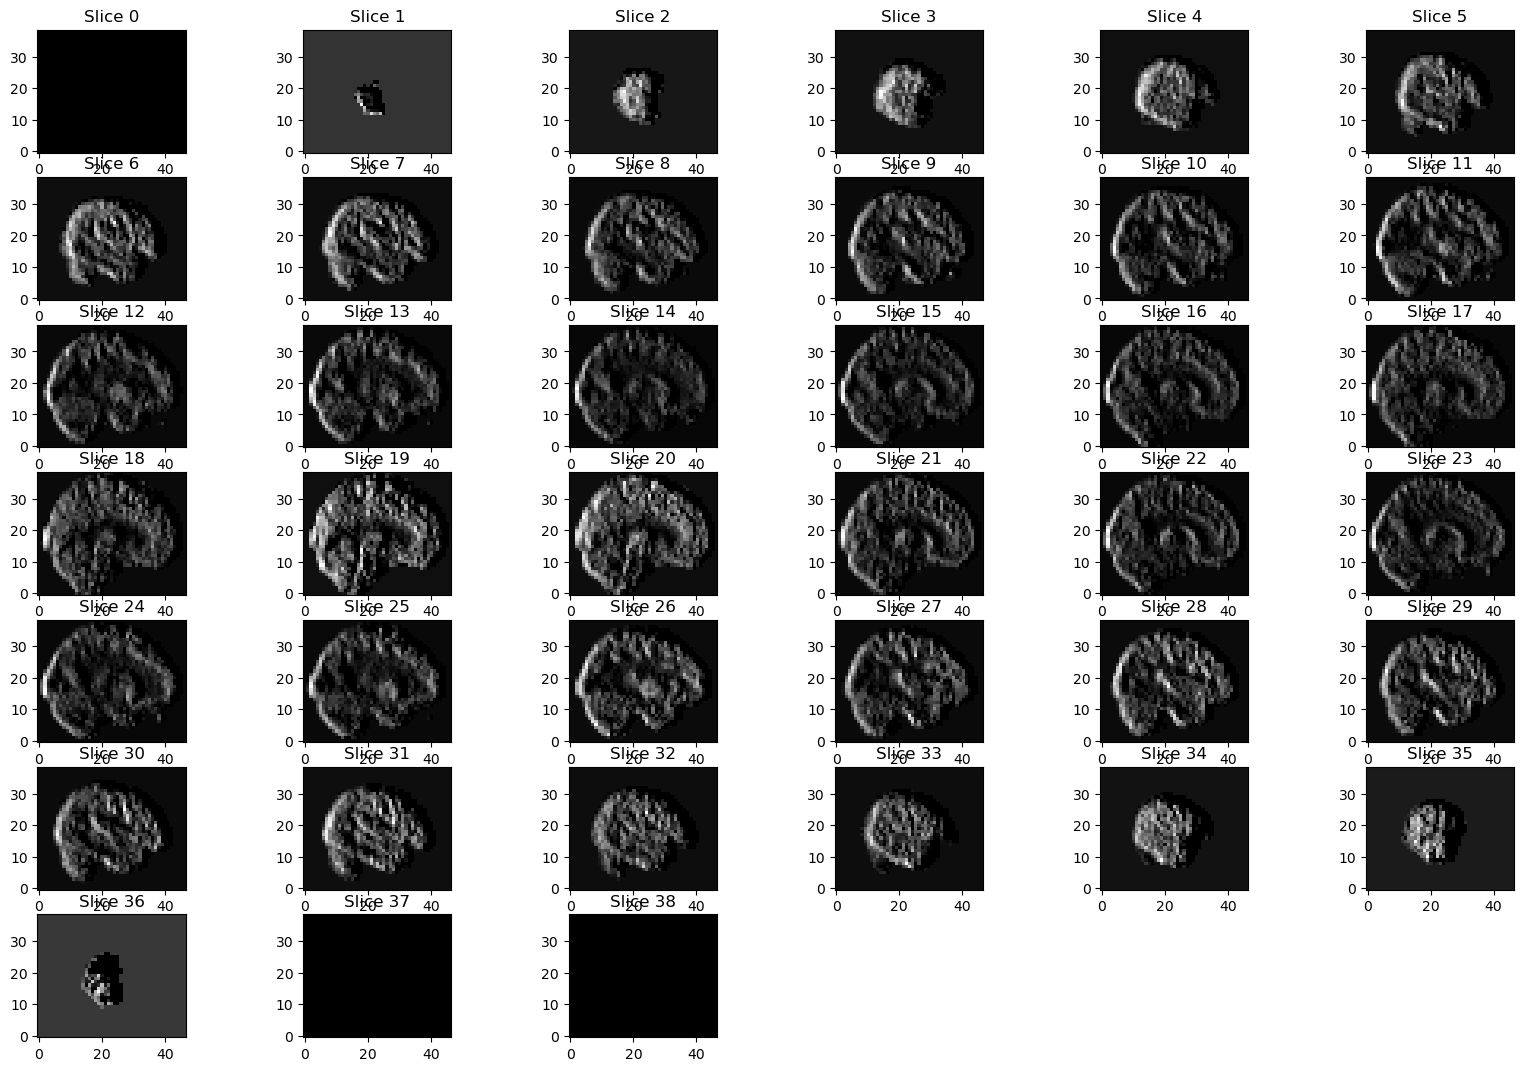

In [24]:
getActivations("cnn1",np.expand_dims(all_data[250,:,:,:],axis=0))

Hm...interesting, some filters look at the outline of the brain, others look at the whole brain without concentrating to much on particular regions!

1/1 [==============================] - 0s 38ms/step
(1, 9, 11, 9, 4)


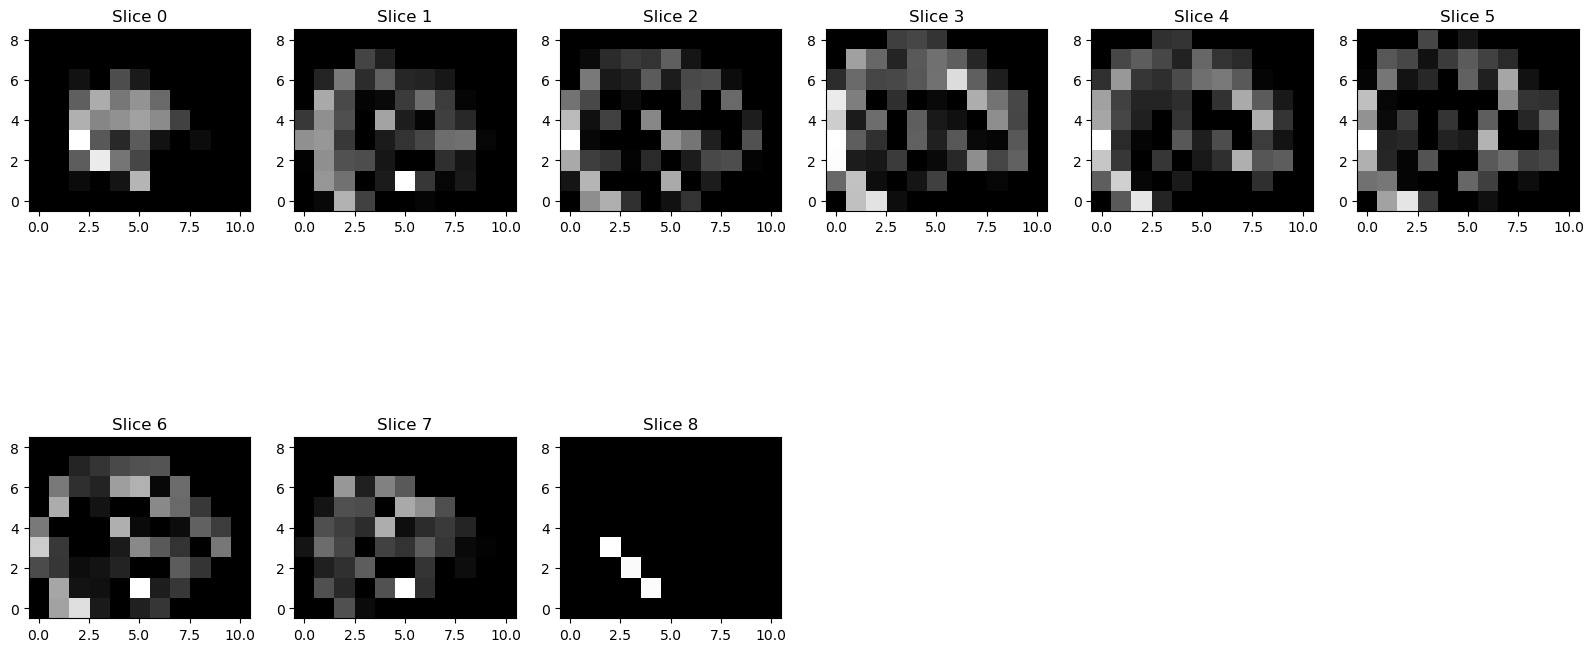

In [25]:
getActivations("cnn2",np.expand_dims(all_data[250,:,:,:],axis=0))

We see something similar, filters look either at the whole brain or its outline!
Another way of looking at what the model has learned, is to plot the filter weights directly:

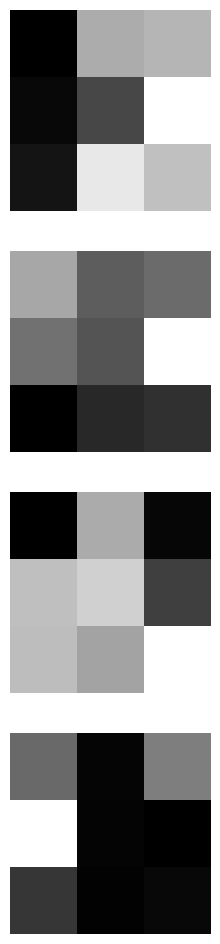

In [26]:
plot_filter_weights_3d(model, "cnn1", 10)

What do you think these filters might detect? The dark squares indicate inhibitory weights and the light squares represent excitatory weights. Filters that gradiually change from light to dark indicate an edge detector. In our case we do not seem to identfy such explict edge detectors. This might indicate that our model does not seem to need edge-detectors for classifications. 

### Explaining model decisions using SHAP
So what specific area of on image promts our network to be exited positively, i.e. classify alzheimers? Lets use SHAP to find out!

In [31]:
import shap

background_data = np.expand_dims(all_data[:100], axis=-1)  
explainer = shap.GradientExplainer(model, background_data)

to_explain = all_data[50:60, :, :, :]
to_explain = np.expand_dims(to_explain, axis=-1)

shap_values = explainer.shap_values(to_explain)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


1/1 [==============================] - 0s 19ms/step
predictions: [[0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]


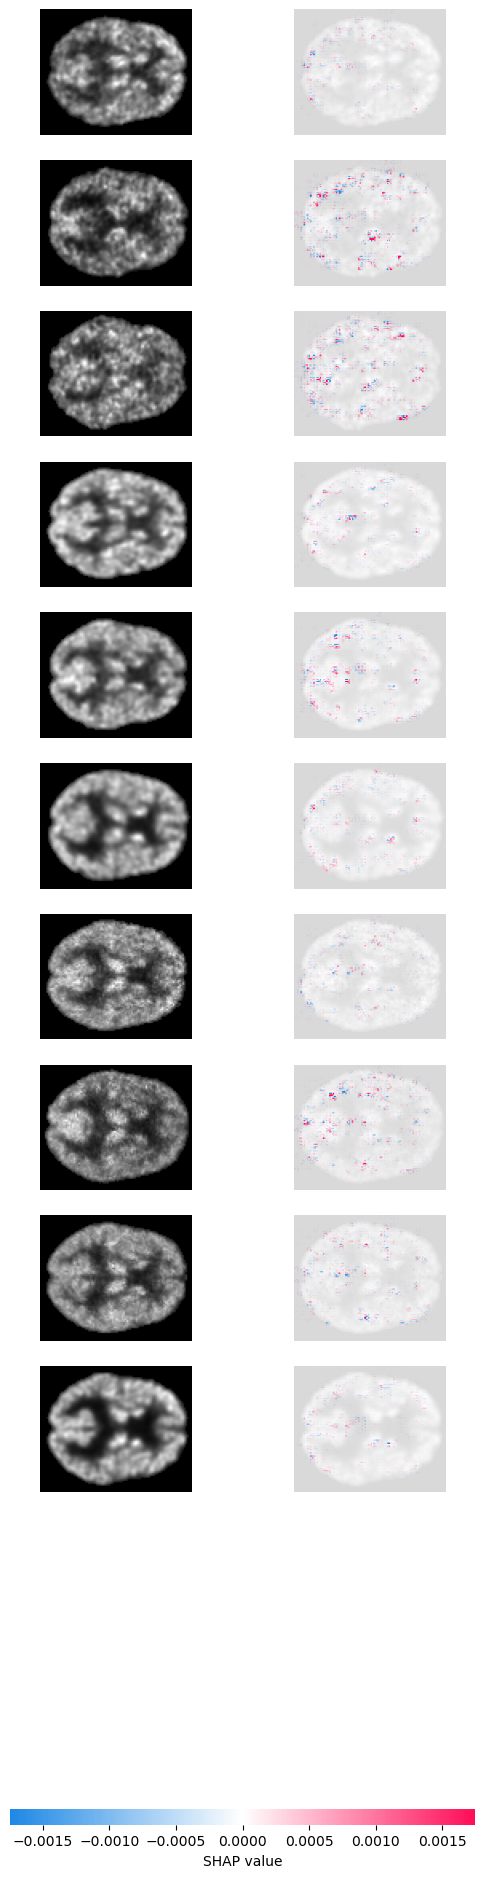

In [36]:
predictions1 = model1.predict(to_explain)
predictions2 = model2.predict(to_explain)
print(f"Model 1 predictions: {np.round(predictions1).tolist()}")
print(f"Model 2 predictions: {np.round(predictions2).tolist()}")

shap.image_plot([x[:, :, :, 0] for x in shap_values1], to_explain[:, :, :, 0].astype("float32"))  # Adjust indices as needed

shap.image_plot([x[:, :, :, 0] for x in shap_values2], to_explain[:, :, :, 0].astype("float32"))  # Adjust indices as needed

Red values correspond to higher model output (alzheimers), while blue correspondes to lower model output (healthy). Try different slices and different brains to explain!